# Detecting fraud using a Live Example

Data available in the transactions.csv is an actual transaction file from a bank.
We don't need the list of fraudsters to train the model as SOM is an unsupervised Deep Learning technique.

##### Our goal is to identify the 'potential fraudsters' and send the list to the expert team for further analysis.

### Importing Libraries & csv files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from progressbar import ProgressBar

In [2]:
tran = pd.read_csv('transactions.csv',parse_dates=['CREATED_DATE']).drop('Unnamed: 0', axis=1)
tran.head(3)

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
0,GBP,3738,COMPLETED,2015-10-11 09:05:43.016,bar,AUS,misc,7285c1ec-31d0-4022-b311-0ad9227ef7f4,CARD_PAYMENT,GAIA,5a9ee109-e9b3-4598-8dd7-587591e6a470
1,GBP,588,COMPLETED,2015-10-11 20:08:39.150,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,28d68bf4-460b-4c8e-9b95-bcda9ab596b5
2,GBP,1264,COMPLETED,2015-10-11 11:37:40.908,NaN,UKR,misc,0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0,CARD_PAYMENT,GAIA,1f1e8817-d40b-4c09-b718-cfc4a6f211df


### Data Cleaning

In [3]:
# We don't need USER_ID and transaction ID for the model. So we will remove them from the tran dataframe
users = tran['USER_ID']
tran = tran[['CURRENCY', 'AMOUNT', 'STATE', 'CREATED_DATE','MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'TYPE', 'SOURCE'
       ]]
tran.head(3)

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE
0,GBP,3738,COMPLETED,2015-10-11 09:05:43.016,bar,AUS,misc,CARD_PAYMENT,GAIA
1,GBP,588,COMPLETED,2015-10-11 20:08:39.150,NaN,CA,misc,CARD_PAYMENT,GAIA
2,GBP,1264,COMPLETED,2015-10-11 11:37:40.908,NaN,UKR,misc,CARD_PAYMENT,GAIA


In [4]:
# Identifying columns with null values
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688651 entries, 0 to 688650
Data columns (total 9 columns):
CURRENCY             688651 non-null object
AMOUNT               688651 non-null int64
STATE                688651 non-null object
CREATED_DATE         688651 non-null datetime64[ns]
MERCHANT_CATEGORY    223065 non-null object
MERCHANT_COUNTRY     483073 non-null object
ENTRY_METHOD         688651 non-null object
TYPE                 688651 non-null object
SOURCE               688651 non-null object
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 47.3+ MB


In [5]:
#Filling null values in 'MERCHANT_CATEGORY' column with value 'unknown'
tran['MERCHANT_CATEGORY'].fillna('Unknown', inplace=True)

#Filling the null values in 'MERCHANT_COUNTRY' as 'unknown'
tran['MERCHANT_COUNTRY'] = tran['MERCHANT_COUNTRY'].str.slice(-3)
tran['MERCHANT_COUNTRY'].fillna('Unknown',inplace=True)

In [6]:
# Converting the 'CREATED_DATE' to unix timestamp
tran['CREATED_DATE'] = tran['CREATED_DATE'].apply(lambda x: int(datetime.datetime.timestamp(x)))

### Feature Scaling

In [7]:
# Creating dummy variables for categorical data
X = tran
X = pd.get_dummies(X,drop_first=True)
num_columns = len(X.columns)

In [8]:
# Minmax scaling to convert all the values to between 0 & 1 
sc = MinMaxScaler()
X = sc.fit_transform(X)

### Building the model

In [9]:
#Building a 2-D matrix of 20x20 
som = MiniSom(20,20,num_columns)

#Assigning random initial weights
som.random_weights_init(X)

#Training the model with 500 iterations
som.train_random(X,500)

### Analysing the results

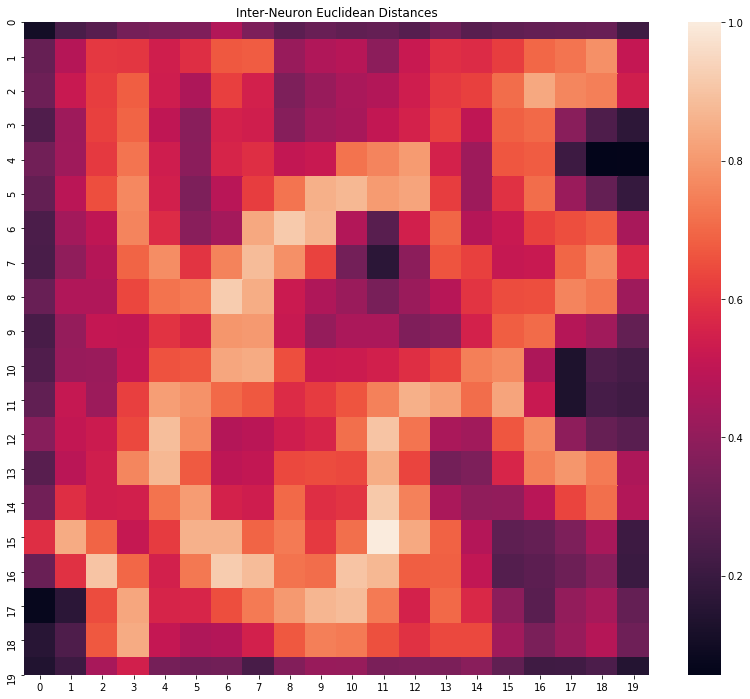

In [10]:
#Returning the matrix of mean inter-neuron euclidean distances of winning nodes
plt.figure(figsize=(14,12))
sns.heatmap(som.distance_map().T)
plt.title('Inter-Neuron Euclidean Distances')
plt.show()

#### Let's find out the transactions with larger than 0.8 euclidean distance.

In [11]:
#Getting the winner node for each of the transaction and putting it in the list w
pbar = ProgressBar()
w=[]
for x in pbar(X):
    w.append(som.winner(x))

100% |########################################################################|


In [21]:
# Assigning the Euclidean distance of each transaction to the index number of that transaction
dist_map = som.distance_map()
cust = {}
for i in range(len(w)):
    cust[i] = dist_map[w[i]]
    
# Converting the cust dictionary to dataframe and joining it to users dataframe
cust = pd.DataFrame.from_dict(cust, orient='index', columns = ['Distance'])
users = users.to_frame().join(cust)

### Probable Fraudsters

Transactions with higher euclidean distances are suspicious. So we will find out the list of those customers and supply the list to the relevant department for further analysis.

In [22]:
probable_fraud_customers = users.drop_duplicates('USER_ID',
                                                 keep='last')[users.drop_duplicates('USER_ID',
                                                                                    keep='last')['Distance'] > 0.8]

In [23]:
probable_fraud_customers

,USER_ID,Distance
2763,41e2ecd4-4d43-49c5-bdc7-b9124ef27187,0.873674
3311,62edb2a5-8b28-466a-9a9a-b3e314f2f771,0.882330
3830,d20a6e48-eba2-4419-98e1-6b20cb7333c7,0.836215
3977,fbe6dfd9-96de-4fde-af16-32e8a0bb7a25,0.882330
4630,10a3ed6c-b711-409d-bb7d-4a0cba9a2ad8,0.873674
...,...,...
688556,846c837d-6c52-48a3-b035-86cf236bec74,0.882330
688579,5fd70cca-1685-40ad-a312-7d387f6911a9,0.873674
688588,d2d6f48a-c3bc-4d98-be4a-e822fcf5fd2d,0.873674
688603,06bb2d68-bf61-4030-8447-9de64d3ce490,0.882330


##### We can investigate these customers to find out whether they are associated with fraudulant transactions or not 